In [122]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

In [123]:
# File paths
TRAIN_CSV = './train.csv'
TEST_CSV = './test.csv'

In [124]:
EMBEDDING_FILE = './GoogleNews-vectors-negative300.bin'
MODEL_SAVING_DIR = './'

In [125]:
# Load training and test set
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [126]:
print (train_df.head(4))

   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  


In [127]:
stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text



In [128]:
train_df['question1'] = train_df['question1'].apply(text_to_word_list)
train_df['question2'] = train_df['question2'].apply(text_to_word_list)
test_df['question1'] = test_df['question1'].apply(text_to_word_list)
test_df['question2'] = test_df['question2'].apply(text_to_word_list)

In [130]:
print (train_df.head(4))

   id  qid1  qid2                                          question1  \
0   0     1     2  [what, is, the, step, by, step, guide, to, inv...   
1   1     3     4  [what, is, the, story, of, kohinoor, koh, -, i...   
2   2     5     6  [how, can, i, increase, the, speed, of, my, in...   
3   3     7     8  [why, am, i, mentally, very, lonely, how, can,...   

                                           question2  is_duplicate  
0  [what, is, the, step, by, step, guide, to, inv...             0  
1  [what, would, happen, if, the, indian, governm...             0  
2  [how, can, internet, speed, be, increased, by,...             0  
3  [find, the, remainder, when, math, 23, ^, 24, ...             0  


In [131]:
print (train_df.iloc[1])

id                                                              1
qid1                                                            3
qid2                                                            4
question1       [what, is, the, story, of, kohinoor, koh, -, i...
question2       [what, would, happen, if, the, indian, governm...
is_duplicate                                                    0
Name: 1, dtype: object


In [223]:
questionwords = []
for value in enumerate(train_df['question1']):
    for word in value[1]:
        questionwords.append(word)
print (len(questionwords))
for value in enumerate(train_df['question2']):
    for word in value[1]:
        questionwords.append(word)
print (len(questionwords))
for value in enumerate(test_df['question1']):
    for word in value[1]:
        questionwords.append(word)
print (len(questionwords))
for value in enumerate(test_df['question2']):
    for word in value[1]:
        questionwords.append(word)
print (len(questionwords))

4512467
9126705
35514748
61988437


In [224]:
for value in questionwords:
    if value == 'motorolla':
        print ('present')
        break
    else:
        continue

present


In [225]:
print (len(questionwords))

61988437


In [226]:
print (len(set(questionwords)))

121325


In [227]:
uniquequestionwords = list(set(questionwords))
# print (len(uniquequestionwords))

In [228]:
for value in uniquequestionwords:
    if value == 'motorolla':
        print ('present')
        break
    else:
        continue

present


In [229]:
print (uniquequestionwords[900:1100])

['leaver', 'rancor', 'forbad', 'digitalocean', 'grandmango', 'twisted', 'tournez', 'buzzing', 'clark', 'flightl', 'catched', 'detergent', 'codeschool', 'doingit', 'haploid', '664', 'iwarp', 'blazin', '90th', 'pesos', 'dataware', '775', 'cdh5', 'quorum', 'chippewa', 'dominica', 'arguements', 'quistion', 'peonies', 'speedstackinggirl', 'interpublic', 'transfusions', 'european', 'hcio2', 'brabus', 'hf', 'klipsch', 'navision', 'psychodynamic', 'poise', '24p423d', 'verballly', 'ganpat', 'conquer', 'cowspiracy', 'assault', 'comduction', 'psilocybe', '538', 'core', 'charat', 'drumnkilly', 'icit', 'envoys', 'birther', 'aliaga', 'appropriative', 'ramses', 'daiwa', 'protonex', '1123', 'ask', 'jhalak', 'repudiate', 'hvng', 'unresolved', 'tanu', 'intestate', 'gomorrah', 'income;', 'ursidae', 'difficilt', 'nursery', 'haan', 'listening;', 'zipperhead', 'dismissive', 'overwhelmingly', 'bencic', 'profiteering', 'joiners', 'snag', 'eathng', 'thats', 'cinemasins', 'resells', 'menisectomy', 'radiologists

In [230]:
# Create a dictionary with unique words

In [231]:
words_to_index = {}
index_to_words = {}

i = 0
for word in uniquequestionwords:
    words_to_index[word] = i
    i = i + 1
    
j=0
for word in uniquequestionwords:
    index_to_words[j] = word
    j=j+1
    
    

In [232]:
import sys
def word_2_integer(wordslist):
    question2integer = []
    for word in wordslist:
        question2integer.append(words_to_index[word])

    return question2integer

word_2_integer(['what', 'is', 'the', 'story', 'of', 'kohinoor'])

[106452, 13057, 318, 51304, 46398, 88515]

In [233]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
train_df['question1'] = train_df['question1'].apply(text_to_word_list)
train_df['question2'] = train_df['question2'].apply(text_to_word_list)
test_df['question1'] = test_df['question1'].apply(text_to_word_list)
test_df['question2'] = test_df['question2'].apply(text_to_word_list)
train_df['question1'] = train_df['question1'].apply(word_2_integer)
train_df['question2'] = train_df['question2'].apply(word_2_integer)
test_df['question1'] = test_df['question1'].apply(word_2_integer)
test_df['question2'] = test_df['question2'].apply(word_2_integer)

In [235]:
train_df.iloc[3]

id                                                              3
qid1                                                            7
qid2                                                            8
question1       [19164, 3082, 79471, 98928, 60784, 56607, 2169...
question2       [2833, 318, 12369, 71016, 53930, 41856, 46938,...
is_duplicate                                                    0
Name: 3, dtype: object

In [236]:
print ( len(words_to_index))

121325


In [237]:

embedding_dim = 300
embeddings = 1 * np.random.randn(len(words_to_index) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in words_to_index.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

# del word2vec

In [238]:
print (embeddings.shape)

(121326, 300)


In [239]:
print (embeddings[1,:])

[-3.04687500e-01 -2.77709961e-03  5.88378906e-02  4.51660156e-02
 -6.25000000e-02 -1.06933594e-01 -3.19824219e-02 -1.31835938e-01
  1.24023438e-01  5.32226562e-02  3.14453125e-01  2.59765625e-01
  2.37304688e-01  2.16796875e-01  2.24304199e-03  2.73437500e-01
 -2.94921875e-01 -2.89062500e-01 -2.08984375e-01 -4.10156250e-02
 -1.36718750e-01 -1.72851562e-01 -1.80664062e-01 -3.97949219e-02
 -1.26953125e-01 -5.93261719e-02 -1.31835938e-02 -1.46484375e-01
  2.26562500e-01 -7.77343750e-01  1.58691406e-02 -7.44628906e-03
  2.04101562e-01 -1.01562500e-01 -3.98437500e-01 -3.28125000e-01
  3.86718750e-01  1.48437500e-01  1.25000000e-01 -3.59375000e-01
  1.30004883e-02 -1.32812500e-01  4.57031250e-01  3.32031250e-01
 -3.32031250e-01 -1.60156250e-01 -2.92968750e-01 -1.63085938e-01
  1.99218750e-01  4.98046875e-01  1.39648438e-01 -1.21093750e-01
 -1.55273438e-01  2.77099609e-02  2.90527344e-02  4.84375000e-01
  7.86132812e-02  1.35742188e-01  3.02734375e-01 -3.75000000e-01
 -3.88671875e-01 -1.42578

In [241]:
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [242]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 25

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, nb_epoch=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

/Users/jac812i/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/jac812i/virtualenvs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 364290 samples, validate on 40000 samples
Epoch 1/25
364290/364290 [==============================] - 1965s 5ms/step - loss: 0.1752 - acc: 0.7460 - val_loss: 0.1612 - val_acc: 0.7629
Epoch 2/25
364290/364290 [==============================] - 1870s 5ms/step - loss: 0.1528 - acc: 0.7857 - val_loss: 0.1499 - val_acc: 0.7885
Epoch 3/25
364290/364290 [==============================] - 1861s 5ms/step - loss: 0.1456 - acc: 0.7975 - val_loss: 0.1459 - val_acc: 0.7949
Epoch 4/25
364290/364290 [==============================] - 1856s 5ms/step - loss: 0.1412 - acc: 0.8043 - val_loss: 0.1426 - val_acc: 0.7987
Epoch 5/25
364290/364290 [==============================] - 1856s 5ms/step - loss: 0.1377 - acc: 0.8095 - val_loss: 0.1414 - val_acc: 0.7976
Epoch 6/25
364290/364290 [==============================] - 1856s 5ms/step - loss: 0.1350 - acc: 0.8137 - val_loss: 0.1385 - val_acc: 0.8089
Epoch 7/25
364290/364290 [==============================] - 1846s 5ms/step - loss: 0.1330 - acc: 0.8170

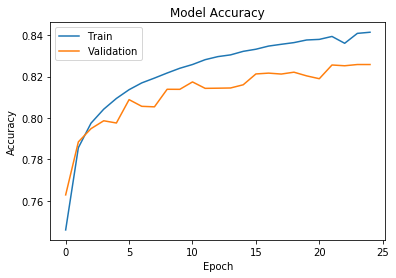

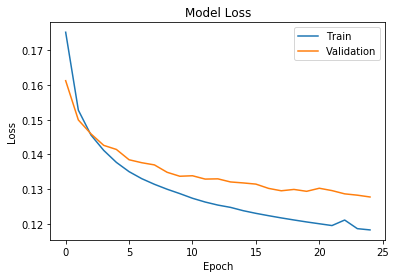

In [245]:
# Plot accuracy
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [251]:
#save the model
malstm.save('quora_model.h5')

In [252]:
malstm.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 245)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 245)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 245, 300)     36397800    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 50)           70200       embedding_1[0][0]                
          